# Trotter Costs
<p style="text-align: center;"><a href="mailto:fmalone@google.com">Fionn Malone</a></p>



We want to estimate the cost of implementing time evolution of a wavefunction:

$$
|\psi(t)\rangle = e^{-i H t}|\psi(0)\rangle
$$

fault tolerantly using qualtran. In practice applying the unitary directly is challenging as the Hamiltonian is made up of non-commuting terms. Note that if we write 
$$
H = H_1 + H_2,
$$
we can always write
$$
e^{-i H t} = \lim_{n\rightarrow\infty} \left(e^{-iH_1 t/m} e^{-iH_2 t/m}\right)^{m}.
$$
With this identity we can use Suzuki-Trotter methods to approximate the exact dynamics through product formulae. For example, the simplest Trotter approximation allows us to approximate the unitary as
$$
e^{-i H t} = \prod_m^{N_t} e^{-iH_1 \delta t} e^{-iH_2 \delta t} + \mathcal{O}(\delta t^2)
$$
where we have $\delta_t = t / N_t$ and the errors are proportional to commutators of the terms in the Hamiltonian. More sophisticated Trotter breakups lead to better accuracy, at the cost of more complicated product formula.

## First Quantized Grid Based Hamiltonian

Ultimately we are interested in understanding the dynamics of real chemical systems. This requires us to study the ab-initio chemistry Hamiltonian which is given as (in atomic units)

\begin{align}
H &= -\frac{1}{2} \sum_i \nabla_i^2 -\sum_{i}\sum_{J} \frac{\zeta_J}{|R_J-r_i|} + \sum_{i < j} \frac{1}{|r_i-r_j|}  + \mathrm{constant} \\
  &= T + U + V.
\end{align}

There are many different ways to represent the Hamiltonian, but here we will adopt a real space grid approach.
That is, we imagine a collection of electrons in a cubic box of length $L$. We discretize real space with a certain resolution given by $\Delta = L/(N-1)$ where $N$ is the number of grid points.  
With this definition of the grid, then each of our $\eta$ electrons can live at discrete real space points $r = (x, y, z)$ where $x = n_x \Delta$, and $n_x \in [-(N-1)/2, (N-1)/2]$. In fact, it is often more convenient in quantum algorithms to consider the unscaled grid points $\bar{x} = x / \Delta$, and work with tuples of integers directly. The scaling factors can be accounted for at a later time. 

To get a better handle on some of these things consider 1D case, and say we chose our grid to have 30 points in each of the positive and negative $x$ directions.
Then $N = 2\times 30 + 1 = 61$. If $L = 15 a_0 $ then $\Delta = 15 / (21-1) \approx 0.25 a_0$, where $a_0$ is the Bohr radius.

In [1]:
import numpy as np
ng = 30
x_int = np.linspace(-ng, ng, 2*ng+1, dtype=int)
L = 15.0
delta = L / (len(x_int) - 1)
print("delta = ", delta)
x_scl = delta * x_int
assert (x_scl[-1] - x_scl[0]) - L < 1e-12

print(f"unscaled grid points = {x_int}")
print(f"scaled grid points   = {x_scl}")


delta =  0.25
unscaled grid points = [-30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15 -14 -13
 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5
   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30]
scaled grid points   = [-7.5  -7.25 -7.   -6.75 -6.5  -6.25 -6.   -5.75 -5.5  -5.25 -5.   -4.75
 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.   -1.75
 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.    1.25
  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75  4.    4.25
  4.5   4.75  5.    5.25  5.5   5.75  6.    6.25  6.5   6.75  7.    7.25
  7.5 ]


With our grid we can now visualize the coulomb potential sampled at these grid points: 

Text(0.5, 1.0, 'Coulomb potential on a grid.')

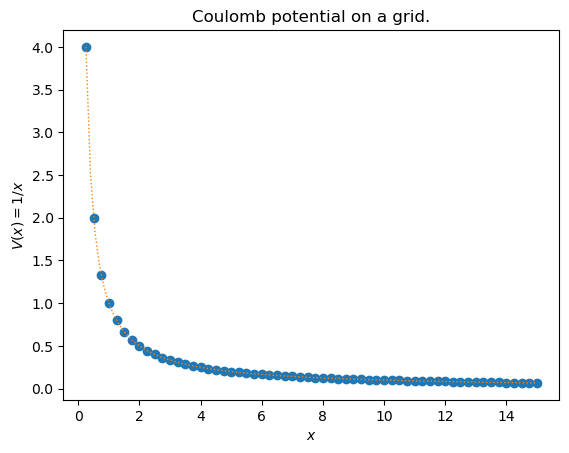

In [2]:
import matplotlib.pyplot as plt 
ij_pairs = np.triu_indices(len(x_int), k=1)
rij = np.unique(np.sqrt((x_scl[ij_pairs[0]] - x_scl[ij_pairs[1]])**(2)))
Vij = 1.0 / rij
plt.plot(rij, Vij, marker='o', lw=0, label="grid")
xmin = np.min(rij)
xmax = np.max(rij)
rij_dense = np.linspace(xmin, xmax, 100)
plt.plot(rij_dense, 1/rij_dense, lw=1, ls=":", label="1/r_{ij}")
plt.xlabel("$x$")
plt.ylabel("$V(x) = 1/x$")
plt.title("Coulomb potential on a grid.")

Ok, now let's look at the potential on our integer grid. The maximum distance should be 60 as our grid ranges from -30 to 30.

xmin = 1, xmax = 60


Text(0.5, 1.0, 'Coulomb potential on a.')

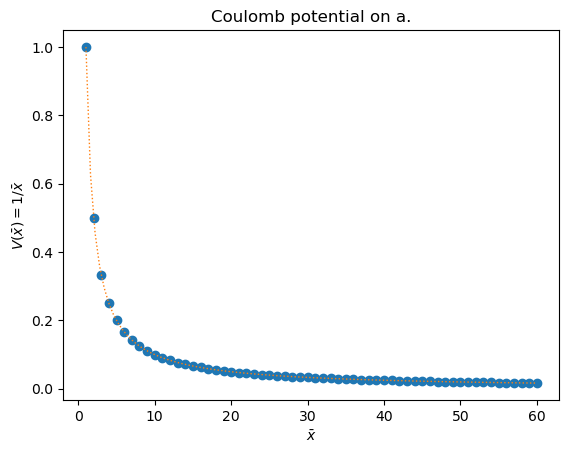

In [3]:
rij_int = np.unique(np.array(np.sqrt((x_int[ij_pairs[0]] - x_int[ij_pairs[1]])**(2)), dtype=int))
Vij_int = 1.0 / rij_int
plt.plot(rij_int, Vij_int, marker='o', lw=0, label="grid")
xmin = np.min(rij_int)
xmax = np.max(rij_int)
print(f"xmin = {int(xmin)}, xmax = {int(xmax)}")
rij_dense = np.linspace(xmin, xmax, 100)
plt.plot(rij_dense, 1/rij_dense, lw=1, ls=":", label="1/r_{ij}")
plt.xlabel(r"$\bar{x}$")
plt.ylabel(r"$V(\bar{x}) = 1/\bar{x}$")
assert np.allclose(Vij_int/delta, Vij) 
assert np.allclose(rij_int*delta, rij) 
plt.title("Coulomb potential on a.")

Great! Now that we have a handle on a grid Hamiltonian let's move onto how to simulate it on a quantum computer. 

Note in the above we assumed that $x>0$ which is not guaranteed. In practice we should this value of the potential to be a very large number.

 
## Quantum Algorithm
Our goal is to perform time evolution for our first quantized grid based Hamiltonian described above. 

Note that the Coulomb terms are diagonal in the position basis while the kinetic term is diagonal in the momentum basis. Thus we can employ a QFT to switch between these bases: 
$$
|\psi(t)\rangle \approx \mathrm{QFT} e^{-i\delta t T} \mathrm{QFT}^{\dagger} e^{-i\delta t U}  e^{-i \delta t V} |\psi(0)\rangle
$$
so that all the terms can be implemented via a gate which implements something of the form $e^{-i \delta t \phi_\alpha }$ via phasing gates.



We can represent our $\eta$-electron wavefunction as 
$$
|\psi\rangle = \sum_{r_1\cdots r_\eta} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle
$$

and recall that each $r$ lives on a grid of size $N = (2 N_g + 1)^3$ if $N_g$ is the number of grid points in each spatial dimension. Thus we will need $\eta$ registers of size $n = 3 \lceil \log N^{1/3}\rceil + 1$ to describe our system.

We will use the approach of Jones et al., which provides the following algorithm for implementing a single Trotter step (for the electron-electron interaction $V$, but the other terms are similar)

\begin{align}
&\sum_{r_1\cdots r_\eta} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle \\
 \rightarrow  &\sum_{r_1\cdots r_\eta} c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle 
     |V(r_1\cdots r_\eta)\rangle
     \hspace{10.4em} \text{Compute pairwise potential in ancilla registers} \\
 \rightarrow  &\sum_{r_1\cdots r_\eta} e^{-i \delta t V(r_1\cdots r_\eta)}
     c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle|V(r_1\cdots r_\eta)\rangle
     \hspace{5.5em} \text{Phase the state with computed potential} \\ 
 \rightarrow &\sum_{r_1\cdots r_\eta} e^{-i \delta t V(r_1\cdots r_\eta)}
     c(r_1, \cdots, r_\eta) |r_1\cdots r_\eta\rangle|0\cdots0\rangle
     \hspace{7.8em} \text{Uncompute potential in ancilla register} \\ 
\end{align}
in the above the ancilla register storing the value of the potential is of size $> 2n + 2$.



To compute the potential we need to evaluate $\frac{1}{r_{ij}} \equiv \frac{1}{|r_i - r_j|}$ which can be done in two steps:

1. compute $|r_{ij}^2\rangle = |(x_i - x_j)^2 + (y_i-y_j)^2 + (z_i - z_j)^2\rangle$ into a register of size $2 n + 2$.
2. compute the inverse square root of the number in this register ($r_{ij}^2$).


The most challenging and expensive part of this step is computing the inverse square root, which can classically be approximated using the Newton-Raphson method.
To do so consider solving $x^{-2} = r_{ij}^2$ which has solution $x^* = \frac{1}{r_{ij}}$. Our Newton-Raphson iteration is then: 

\begin{align}
a_{n+1} &= a_{n} - \frac{a_n^3(1-r_{ij}^2 a_n^2)}{-2 a_n^2} \\
        &= \frac{1}{2}a_n\left(3-a_n^2 r_{ij}^2\right).
\end{align}

In the original work of Jones et al. it was suggested that 5 or more iterations was sufficient to obtain acceptable accuracy. However, one needs a good initial guess for this to be the case, and as the Newton Raphson step is by far the most costly part of the quantum algorithm, it would be nice to reduce this prefactor.

In the fusion paper this method is improved upon by using a hybrid approach based upon using QROM to load a good approximation to our function followed by a single step of Newton-Raphson. A further optimization is introduced to include the scaling factors necessary for the potential directly in the Newton-Raphson step (i.e. all the timestep and factors of two.)



## Function interpolation

The basic idea is to first fit a polynomial to $\frac{1}{r_{ij}}$ to use as input for a Newton-Raphson step. In practice we do not want to try to fit $r_{ij}^{-1}$ over the entire range of values as this will lead to a poor quality fit. Instead we combine two ideas: piecewise interpolation and scaling. Piecewise interpolation allows us to boost the accuracy of our fit by splitting our domain into $k$ subintervals and fitting a polynomial in these smaller subintervals, which can then be pieced together on fly depending on the input value $\bar{x}$. The second idea is to use the scaling properties of our function to only fit in a small subinterval, and appropriately scaling it if we need to know its value outside of this interval. That is, we know that $\frac{1}{\sqrt{x}} = \frac{1}{\sqrt{a}\sqrt{x'}}$ for $x' \in [1, 2]$, say.

In practice we split the interval $[1, 2]$ in half, and fit the polynomial 

$$
\frac{1}{\sqrt{x}} \approx a_0 - a_1 (x-1) + a_2 (x-1)^2 - a_3 (x-1)^3
$$

for $x \in [1, 3/2]$ and

$$
\frac{1}{\sqrt{x}} \approx b_0 - b_1 (x-3/2) + b_2 (x-3/2)^2 - b_3 (x-3/2)^3
$$

for $x \in [3/2, 2]$.

First let's see how these polynomials compare within their domains of definition:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(1e-06, 0.0001)

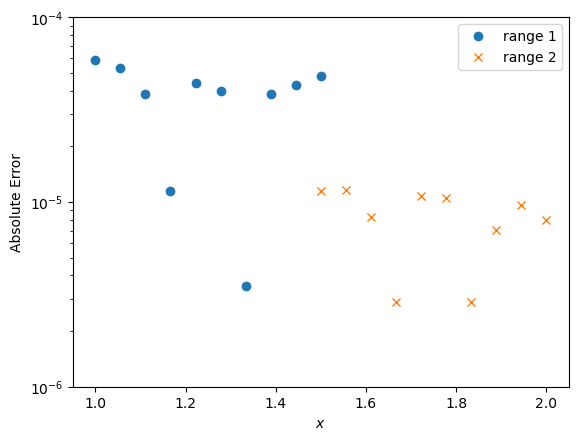

In [4]:
from qualtran.bloqs.chemistry.trotter.inverse_sqrt import get_inverse_square_root_poly_coeffs
coeffs_one, coeffs_two = get_inverse_square_root_poly_coeffs()
a0, a1, a2, a3 = coeffs_one
b0, b1, b2, b3 = coeffs_two

def polynomial_approx_range_one(x: float):
    return a0 - (x-1) * (a1 - (x-1) * (a2 - a3*(x-1)))

def polynomial_approx_range_two(x: float):
    return b0 - (x-1.5) * (b1 - (x-1.5) * (b2 - b3*(x-1.5)))

xs_one = np.linspace(1.0, 1.5, 10)
poly_fit_one = polynomial_approx_range_one(xs_one)
xs_two = np.linspace(1.5, 2.0, 10)
poly_fit_two = polynomial_approx_range_two(xs_two)
plt.plot(xs_one, np.abs(1.0 / xs_one**0.5 - poly_fit_one), marker='o', lw=0, label="range 1")
plt.plot(xs_two, np.abs(1.0 / xs_two**0.5 - poly_fit_two), marker='x', lw=0, label="range 2")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Absolute Error")
plt.yscale("log")
plt.ylim([1e-6, 1e-4])

Ok, that's pretty good. How does this compare after our step of Newton Raphson?

In [5]:
def newton_raphson_step(x, y0, delta=0.0):
    # This odd delta shift let's us reduce the error by about a factor of two.
    # Try commenting it out and see what the max error is after this step.
    yprime = 0.5 * y0 * (3 + delta - y0**2 * x) 
    return yprime
delta_range_one = 5.1642030908180720584e-9
delta_range_two = 3.6279794522852781448e-10

In [6]:
nr_one = newton_raphson_step(xs_one, poly_fit_one, delta=delta_range_one)

In [7]:
nr_two = newton_raphson_step(xs_two, poly_fit_two, delta=delta_range_two)

(1e-12, 1e-08)

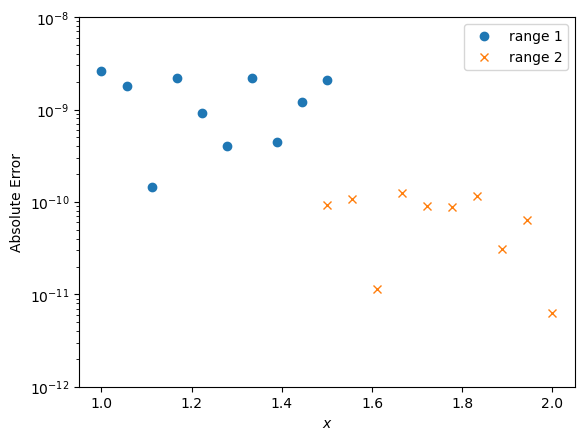

In [8]:
plt.plot(xs_one, np.abs(1.0 / xs_one**0.5 - nr_one), marker='o', lw=0, label="range 1")
plt.plot(xs_two, np.abs(1.0 / xs_two**0.5 - nr_two), marker='x', lw=0, label="range 2")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("Absolute Error")
plt.yscale("log")
plt.ylim([1e-12, 1e-8])

Ok great! We have a very accurate approximation to our function using if we can load some polynomial coefficients and perform some arithmetic. Next we will describe how we can use variable spaced QROM to efficiently load only a small amount of data to enable this procedure. 

## Variable Spaced QROM and Fitting the Entire Domain

In this section we will discuss how we can use QROM along with function interpolation to approximate our function over the entire domain to high precision. But first let us convince ourselves that our two subintervals are sufficient and we can indeed fit our function by appropriately scaling our polynomial. For reasons that will become clear later, let us first group our allowed values of $r_{ij}^2$ in a logarithmic fashion as $0, 1, 2, 3, [4, 5], [6, 7], [8, 11], [12, 15], [16, 23], [24, 31], ...$ and so on. We can associate each of these integer intervals with our polynomial domains by noting that $[4, 5] = 2^2[1, 3/2]$, $[12, 15] = 2^3[3/2, 2]$, etc. Thus, we can evaluate our function for any value $r_{ij}^2$ after determining which "bin" it belongs to, determining the appropriate power of two, and scaling our polynomial appropriately. Let's test this below:

max error = 5.8675108801198306e-05 vs expected error = 3.0517578125e-05
max error after NR step = 2.5821014215665627e-09


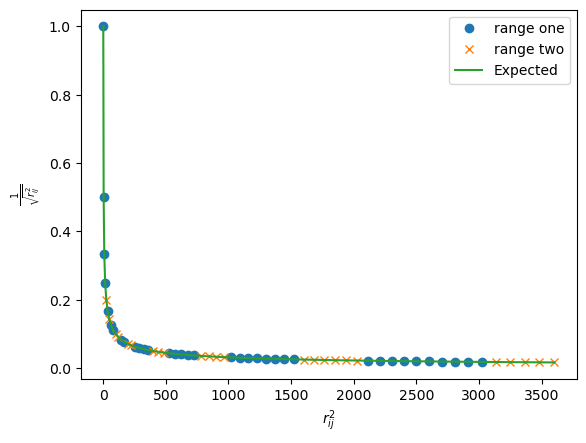

In [9]:
from typing import Union
from numpy.typing import NDArray
# Recall we are using x in place of rij^2 here.
def polynomial_approx_range_one_scaling(x: Union[float, NDArray[float]], scale_power: int):
    r"""Evaluate the polynomial approximation to 1/\sqrt{x}.

    Args:
        x: Where to evaluate the polynomial. This is rij^2. 
        scale_power: The power of two required to scale x back into the interval [1, 3/2].
    
    Returns:
        y: The polynomial approximation to 1/\sqrt{x} (i.e. 1/r_{ij}) in the first interval [1, 3/2].
    """
    a0_scl = a0 / 2**(scale_power/2.0)
    a1_scl = a1 / 2**(3*scale_power/2.0)
    a2_scl = a2 / 2**(5*scale_power/2.0)
    a3_scl = a3 / 2**(7*scale_power/2.0)
    return a0_scl - (x-2**scale_power) * (a1_scl - (x-2**scale_power) * (a2_scl - a3_scl*(x-2**scale_power)))

def polynomial_approx_range_two_scaling(x: float, scale_power: int=0):
    r"""Evaluate the polynomial approximation to 1/\sqrt{x}.

    Args:
        x: Where to evaluate the polynomial. This is rij^2. 
        scale_power: The power of two required to scale x back into the interval [3/2, 2].
    
    Returns:
        y: The polynomial approximation to 1/\sqrt{x} (i.e. 1/r_{ij}) in the first interval [3/2, 2].
    """
    b0_scl = b0 / 2**(scale_power/2.0)
    b1_scl = b1 / 2**(3*scale_power/2.0)
    b2_scl = b2 / 2**(5*scale_power/2.0)
    b3_scl = b3 / 2**(7*scale_power/2.0)
    return b0_scl - (x-1.5*2**scale_power) * (b1_scl - (x-1.5*2**scale_power) * (b2_scl - b3_scl*(x-1.5*2**scale_power)))

# Number of bits to represent the grid
nbits = (2*ng + 1).bit_length()
# Number of bits for r^2
nbits_rsq = 2*nbits + 2
# Here we determine the appropriate bins into which we subdivide our r_{ij}^2 values.
bins_one = {0: [1], 1: [2]} 
bins_two = {1: [3]}
rsq = 2**2
while rsq < 2**nbits_rsq:
    bl = int(rsq).bit_length() - 1
    bins_one[bl] = [k for k in range(rsq, rsq+2**(bl-1))]
    rsq += 2**(bl-1)
    bins_two[bl] = [k for k in range(rsq, rsq+2**(bl-1))]
    rsq += 2**(bl-1)

# Fit the polynomial over the whole range.
poly_one = []
poly_two = []
rsq_one = []
rsq_two = []
# check for our actual allowed values of r^2 for the grid
for rsq in rij_int**2:
    bl = int(rsq).bit_length() - 1
    if rsq in bins_one[bl]:
        poly_one.append(polynomial_approx_range_one_scaling(rsq, scale_power=bl))
        rsq_one.append(rsq)
    elif rsq in bins_two[bl]:
        poly_two.append(polynomial_approx_range_two_scaling(rsq, scale_power=bl))
        rsq_two.append(rsq)
    else:
        raise ValueError("Could not find bin for rsq.")

plt.plot(rsq_one, poly_one, marker='o', lw=0, label='range one')
plt.plot(rsq_two, poly_two, marker='x', lw=0, label='range two')
plt.plot(rij_int**2, 1/rij_int, label='Expected')
plt.legend()
plt.xlabel("$r_{ij}^2$")
plt.ylabel(r"$\frac{1}{\sqrt{r_{ij}^2}}$")
# Check the global error
combined_r = np.concatenate([rsq_one, rsq_two])
ix = np.argsort(combined_r)
combined = np.concatenate([poly_one, poly_two])[ix]
nr_one = newton_raphson_step(np.array(rsq_one), np.array(poly_one), delta_range_one)
nr_two = newton_raphson_step(np.array(rsq_two), np.array(poly_two), delta_range_two)
combined_nr = np.concatenate([nr_one, nr_two])[ix]
print(f"max error = {np.max(np.abs(combined - 1/rij_int))} vs expected error = {2**(-15)}")
print(f"max error after NR step = {np.max(np.abs(combined_nr - 1/rij_int))}")

Ok! You might be wondering what is special about the intervals we chose to bin our integer $r_{ij}^2$ values by, and how QROM is connected with this. We'll try to explain that now.

### QROM
Recall that ultimately we need to load our polynomial coefficients onto the quantum computer before we can evaluate the inverse square root. Data loading can be achieved through QROM which implements: 

$$
\mathrm{QROM}_d \sum_l \alpha_l |l\rangle|0\rangle = \sum_l \alpha_l |l\rangle|d_l\rangle.
$$

That is, given a selection register $l$, QROM can load the binary representation of the $l$-th data element of $d$ into a target register of a given size.
In our case $|r_{ij}^2\rangle$ is the selection register of size $2 n + 2$, and we want to load $b$-bit binary representations of our polynomial coefficients $\{a_0, a_1, a_2, a_3\}$ and $\{b_0, b_1, b_2, b_3\}$ for the two ranges.

In principle we could load all of the (scaled) coefficients for each value of $r_{ij}$ in the register, but this would incur a cost that goes like $L-1$ Toffolis, where $L=2^{2n + 2}$ which would be unacceptably large. But we just saw that much of this data would be duplicated as we only need the coefficients for each subinterval, of which there are a logarithmic amount. Fortunately we can exploit the structure of the unary iteration circuit to exploit this redundancy and significantly reduce our costs and arrive at variably space QROM.

To understand where the reduction in cost comes from, consider the unary iteration circuit which is used during QROM construction. There, depending on the particular binary representation of the selection register, different parts of the tree are traversed before writing the data to a register. As we only care about certain subintervals (which were conveniently chosen as powers of two), we can delete parts of our unary iteration circuit where we want to repeat the data for that range of integers. The number of allowed integers in each range is determined in the following way: for the starting integer of the range $l$: if $k$ is the most significant bit of $l$, then the number of integers in our range is $2^{k-2}$ (we only bin integers when $k \ge 2$). This is identical to how we set up our binning procedure earlier. Below is some code to generate the ranges given the values of the most significant bits of the selection register. 

In [10]:
nbits = 6
nbits_rij_sq = 2 * nbits + 2
print(f"L = {2**nbits_rij_sq}")
hit = True 
g = 0
for l in range(0, 2**nbits_rij_sq):
    k = l.bit_length()
    if k > 2:
        if l & (1 << (k-2)) and not hit:
            hit = True
            print(f"l = {l:0{nbits_rij_sq}b}, range = [{l:5d}, {l+2**(k-2)-1:5d}], length = {2**(k-2):>4d} {k}")
            g += 1
        if not l & (1 << (k - 2)) and hit:
            hit = False
            print(f"l = {l:0{nbits_rij_sq}b}, range = [{l:5d}, {l+2**(k-2)-1:5d}], length = {2**(k-2):>4d} {k}")
            g += 1
# Add four to account for 0, 1, 2, 3
print(f"number of distinct regions g = {g + 4}. Toffoli cost g - 2 = {g - 2 + 4}")

L = 16384
l = 00000000000100, range = [    4,     5], length =    2 3
l = 00000000000110, range = [    6,     7], length =    2 3
l = 00000000001000, range = [    8,    11], length =    4 4
l = 00000000001100, range = [   12,    15], length =    4 4
l = 00000000010000, range = [   16,    23], length =    8 5
l = 00000000011000, range = [   24,    31], length =    8 5
l = 00000000100000, range = [   32,    47], length =   16 6
l = 00000000110000, range = [   48,    63], length =   16 6
l = 00000001000000, range = [   64,    95], length =   32 7
l = 00000001100000, range = [   96,   127], length =   32 7
l = 00000010000000, range = [  128,   191], length =   64 8
l = 00000011000000, range = [  192,   255], length =   64 8
l = 00000100000000, range = [  256,   383], length =  128 9
l = 00000110000000, range = [  384,   511], length =  128 9
l = 00001000000000, range = [  512,   767], length =  256 10
l = 00001100000000, range = [  768,  1023], length =  256 10
l = 00010000000000, range = 

We see by the bit pattern that we can use the $k-1$ st bit to toggle between our two ranges [1, 3/2] and [3/2, 2]. The total Toffoli cost is then just g - 2, which is 26 if $r_{ij}^2$ is stored with 14 bits. Note we can store the coefficients to high precision as there is only a small clifford overhead associated with this. In the fusion paper 15 bits of precision is suggested as sufficient. 

To summarize we:

1. Fit our function $1/x$ in two intervals [1, 3/2] and [3/2, 2].
2. Given a value of $r_{ij}$, use variably spaced qrom to output the appropriately scaled polynomial coefficients.
3. Evaluate the polynomial.
4. Perform a single step of Newton Raphson.
5. Apply a phase to our wavefunction.

## Trotter Unitaries

Ok, now that we have the setup straight in our heads lets build our bloqs and perform resource estimations!

## Kinetic Energy Bloq
Recall that the kinetic energy is diagonal in the momentum basis, which we are assuming our state is in following a ```QFT```. The basic algorithm is then

1. For each electron $i$ compute $|\mathbf{k}^2 \rangle = |k_x^2 + k_y^2 + k_j^2\rangle$ of size $2n + 2$.
2. Apply $e^{-i\frac{\delta t}{2} \sum_i k^2_i }|\psi\rangle = \prod_i e^{-i\frac{\delta t}{2} k_i^2}|\psi\rangle$, where the equality holds as each term in the sum commutes.

Our bloq implementing this is below:

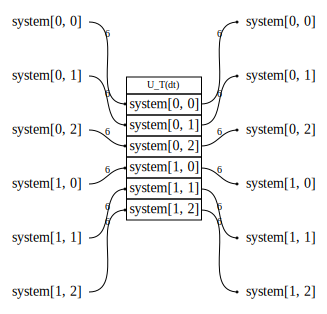

In [11]:
from qualtran.bloqs.chemistry.trotter import KineticEnergy 
from qualtran.drawing import show_bloq
num_elec = 2
num_grid_each_dim = 2*10 + 1
ke_bloq = KineticEnergy(num_elec, num_grid_each_dim)
show_bloq(ke_bloq)

In [12]:
print(ke_bloq.t_complexity())

T-count:   2264
Rotations: 0
Cliffords: 0



## Potential Energy Bloq

Here we consider the electron-electron interaction
\begin{align}
V &= \sum_{i < j} \frac{1}{|r_i-r_j|} \\
  &= \sum_{i < j} V_{ij}
\end{align}
Again, as the individual terms commute (diagonal in our real space grid basis), we can decompose our unitary into a product of $\eta (\eta - 1)$ unitaries implementing all of the $V_{ij}$ pair potentials:

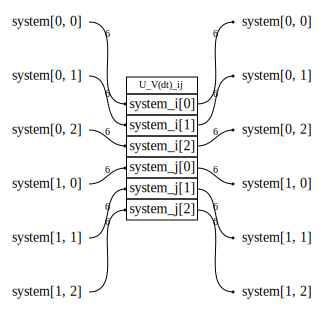

T-count:   10148
Rotations: 0
Cliffords: 2477



In [13]:
from qualtran.bloqs.chemistry.trotter import PotentialEnergy
from qualtran.drawing import show_bloq, show_call_graph
num_elec = 2
num_grid_each_dim = 2*10 + 1
coeffs_a = []
pe_bloq = PotentialEnergy(num_elec, num_grid_each_dim)
show_bloq(pe_bloq.decompose_bloq())
print(pe_bloq.t_complexity())

Our $V_{ij}$ bloq then implements the steps discussed previously, let's have a look:

In [14]:
from qualtran.bloqs.chemistry.trotter import PairPotential
from qualtran.bloqs.chemistry.trotter.inverse_sqrt import build_qrom_data_for_poly_fit
poly_coeffs = get_inverse_square_root_poly_coeffs()
num_elec = 2
num_grid_each_dim = 2*10 + 1
nbits = 6
qrom_data = build_qrom_data_for_poly_fit(2*nbits+2, 15, poly_coeffs)
qrom_data = tuple(tuple(int(k) for k in d) for d in qrom_data)
pp_bloq = PairPotential(nbits, qrom_data, poly_bitsize=15)
print(pp_bloq.t_complexity())

T-count:   10148
Rotations: 0
Cliffords: 2477


## Comparison to Costs in Paper

We're now in a position to compare our qualtran costs to those in the paper, which were rough estimates.

In [15]:
import attrs
import cirq

from qualtran.resource_counting import SympySymbolAllocator
from qualtran.drawing import GraphvizCounts
from qualtran.bloqs.util_bloqs import Split, Join, Allocate, Free
from qualtran.bloqs.basic_gates.rotation import RotationBloq
from qualtran.cirq_interop import CirqGateAsBloq
from qualtran.bloqs.and_bloq import And

# Ignore some parts of the decomposition which aren't helpful for visualization.
ssa = SympySymbolAllocator()
phi = ssa.new_symbol('phi')
and_cv0 = ssa.new_symbol('cv0')
and_cv1 = ssa.new_symbol('cv1')

def custom_repr(self):
    selection_repr = repr(self.selection_bitsizes)
    target_repr = repr(self.target_bitsizes)
    return (f"QROM(selection_bitsizes={selection_repr}, "
        f"target_bitsizes={target_repr}, num_controls={self.num_controls})"
    )

cirq_cliffords_ignore = (
    cirq.ops.common_gates.HPowGate,
    cirq.ops.common_gates.XPowGate,
    cirq.ops.common_gates.YPowGate,
    cirq.ops.common_gates.ZPowGate,
    cirq.ops.common_gates.CXPowGate,
)
def generalize(bloq):
    if isinstance(bloq, CirqGateAsBloq):
        if isinstance(bloq.gate, And) and (len(bloq.gate.cv) == 2):
            return And(cv1=and_cv0, cv2=and_cv1, adjoint=bloq.gate.adjoint)
        if isinstance(bloq.gate, cirq_cliffords_ignore):
            return None
    if isinstance(bloq, (Join, Split, Allocate, Free)):
        return None
    if isinstance(bloq, RotationBloq):
        return attrs.evolve(bloq, angle=phi)
    return bloq

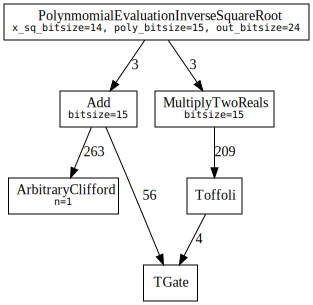

In [16]:
from qualtran.bloqs.chemistry.trotter.inverse_sqrt import PolynmomialEvaluationInverseSquareRoot 
poly_eval = PolynmomialEvaluationInverseSquareRoot(14, 15, 24)
graph, sigma = poly_eval.call_graph(generalizer=generalize)
show_call_graph(graph)

In [17]:
paper_cost = 4 * (3*15**2 + 45)
print(f"qualtran cost = {poly_eval.t_complexity().t} vs paper_cost = {paper_cost} T gates")

qualtran cost = 2676 vs paper_cost = 2880 T gates


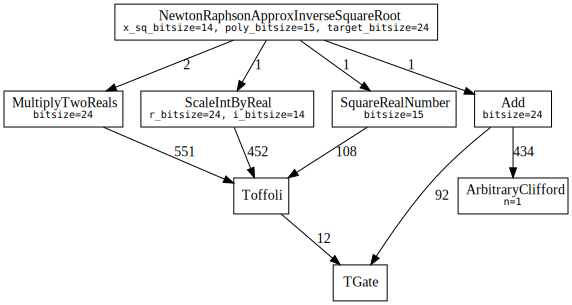

In [18]:
from qualtran.bloqs.chemistry.trotter.inverse_sqrt import NewtonRaphsonApproxInverseSquareRoot
nr = NewtonRaphsonApproxInverseSquareRoot(14, 15, 24)
graph, sigma = nr.call_graph(generalizer=generalize)
show_call_graph(graph)

In [19]:
paper_cost = 4 * (2136 - 3*15**2 - 45)
print(f"qualtran cost = {nr.t_complexity().t} vs paper cost = {paper_cost} T gates")

qualtran cost = 5656 vs paper cost = 5664 T gates


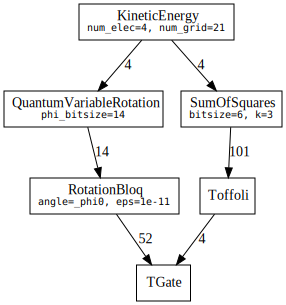

In [20]:
from qualtran.bloqs.chemistry.trotter import KineticEnergy 
ke = KineticEnergy(4, 21)
graph, sigma = ke.call_graph(generalizer=generalize)
show_call_graph(graph)

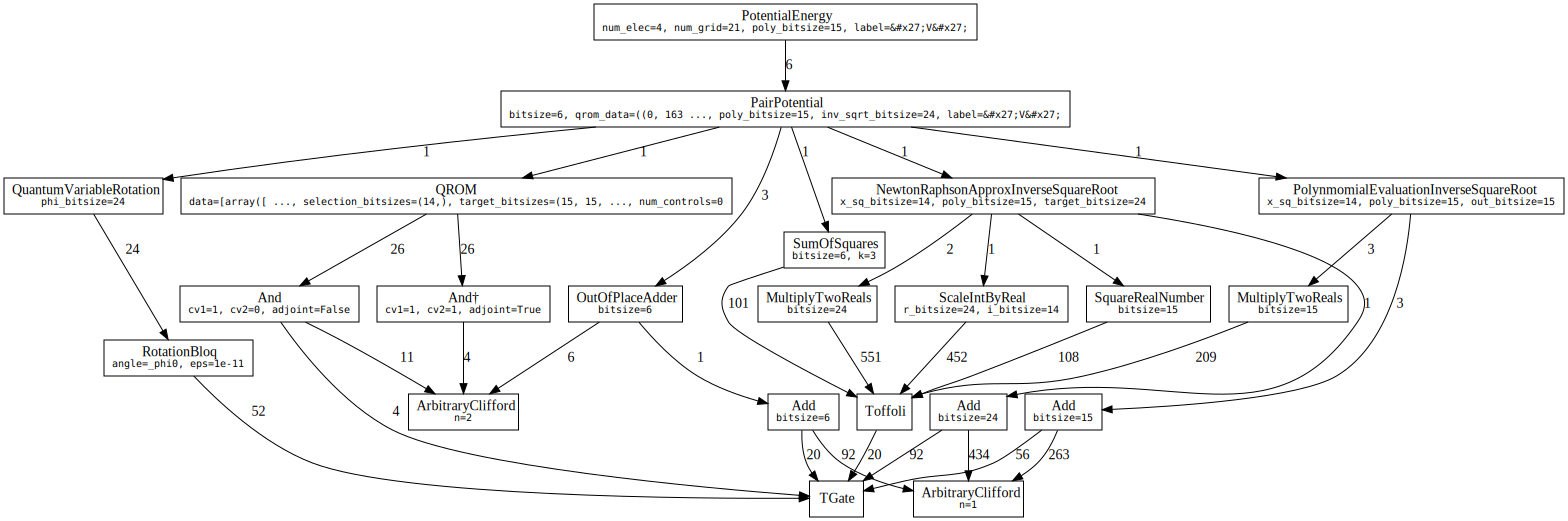

In [21]:
from qualtran.bloqs.chemistry.trotter import PotentialEnergy 
pe = PotentialEnergy(4, 21)
graph, sigma = pe.call_graph(generalizer=generalize)
show_call_graph(graph)

Let's look at the costs of doing just the pair potential. Note that the Fusion paper does not count the cost of applying the phase and also our qualtran estimates does not account for the bit shifting necessary to deal with small values of $x$. The bit shifting cost is about $n(n+1) + 15n$, which we do not include in the comparison below. The cost of uncomputing the arithmetic is also ignored in both estimates.

In [22]:
from qualtran.bloqs.chemistry.trotter import PairPotential
nbits = 6
poly_coeffs = get_inverse_square_root_poly_coeffs()
qrom_data = build_qrom_data_for_poly_fit(2*nbits+2, 15, poly_coeffs)
qrom_data = tuple(tuple(int(k) for k in d) for d in qrom_data)

pe = PairPotential(6, qrom_data)
graph, sigma = pe.call_graph(generalizer=generalize)
paper_cost = (
    2136 # poly interp + newton raphson
    + (3*nbits**2 - nbits - 1) # sum of squares
    + (4*nbits + 2) # QROM
)
print(f"qualtran_cost = {pe.t_complexity().t-24*52} vs paper_cost = {4*paper_cost}")

qualtran_cost = 8900 vs paper_cost = 9052


## Appendix

Note in practice we really use fixed point representation of floating numbers.

### Fixed point and binary arithmetic

To evaluate the polynomial and Newton-Raphson step we need fixed-point arithmetic (addition, multiplication, squaring and scaling). Recall that fixed-point real valued (between 0 and 1) numbers are approximated as (using a convention where the most significant bit is yielded first)

$$
\kappa = \sum_{l=0}^{b_r-1} \kappa_l/2^{l+1}, \ \ \ \ \kappa_l \in \{0, 1\}
$$

while (positive) integers can be represented as

$$
\lambda = \sum_{l=0}^{b_i-1} 2^{b_i - l} \lambda_l, \ \ \ \ \lambda_l \in \{0, 1\}
$$